In [16]:
 %matplotlib inline
from __future__ import division
import tensorflow as tf
import numpy as np
import h5py
import os
import six
import shutil
import tempfile
from six.moves import range
import itertools
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
import PIL
from tqdm import tqdm
from PIL import ImageOps
from PIL import ImageEnhance
import matplotlib.font_manager
from PIL import ImageDraw, ImageFont, ImageFilter

In [17]:
h5py.version.version

'2.7.0'

In [18]:
data_dir = '../../data'
crop_size = (64, 48)

h5 = h5py.File(os.path.join(data_dir, 'train.hdf5'),mode='r+')

In [19]:
print("{:10}| {:10}| {:30}".format("name", "dtype", "shape"))
print("-" * 40)
for name, dset in h5.items():
    print("{:10}| {:10}| {:30}".format(name, str(dset.dtype), str(dset.shape)))

name      | dtype     | shape                         
----------------------------------------
image     | uint8     | (10722, 60, 80)               
speed     | float32   | (10722, 1)                    
steering  | float32   | (10722, 1)                    
timestamp | float64   | (10722, 1)                    


In [20]:
def data_generator(batch_size=128, n_epoch=-1):
    n = len(h5['image'])
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_batches = n // batch_size
    if n_epoch == -1:
        n_epoch = 1000000000
    for epoch in range(n_epoch):
        for b in range(0, n, batch_size):
            batch_idx = np.sort(idx[b:b+batch_size])
            yield {
                'image': h5['image'][batch_idx, :, :],
                'steering': h5['steering'][batch_idx, :],
                'speed': h5['speed'][batch_idx, :],
            }
    
batch = next(data_generator())

In [21]:
batch['image'].min(), batch['image'].max(), 

(15, 208)

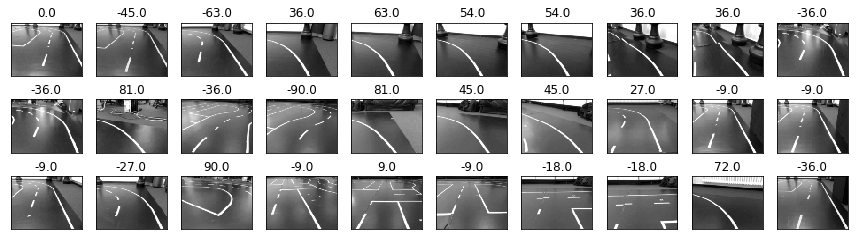

In [22]:
fig, axes = plt.subplots(3, 10, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    ax.set_title("{:.1f}".format(float(180 / np.pi * batch['steering'][i])))
    ax.imshow(batch['image'][i], cmap='gray')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

#### number of seconds per epoch

In [23]:
#%%timeit -n 3

#for batch in data_generator(n_epoch=1):
#    pass

In [24]:
batch = next(data_generator())

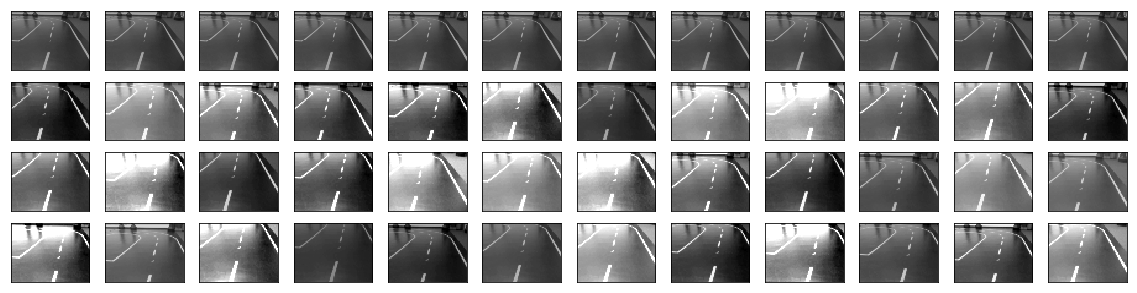

In [25]:
def augment_img(img):
    width, height = img.size
    max_crop_left = img.size[0] - crop_size[0]
    max_crop_upper = img.size[1] - crop_size[1]
    left = np.random.choice(max_crop_left)
    upper = np.random.choice(max_crop_upper)
    img = img.crop([left, upper, left + crop_size[0], upper + crop_size[1]])
                    #width - left, height - upper])
    brightness = ImageEnhance.Brightness(img)

    img = brightness.enhance(np.random.uniform(0.75, 2.5))
    contrast = ImageEnhance.Contrast(img)
    img = contrast.enhance(np.random.uniform(0.75, 2.5))
    return img

images = [PIL.Image.fromarray(x) for x in batch["image"]]
img = images[0]
fig, axes = plt.subplots(4, 12, figsize=(20, 5))

for ax in axes[:1].flat:
    ax.imshow(np.array(img), cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])
for ax in axes[1:].flat:
    ax.imshow(np.array(augment_img(img)), cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])

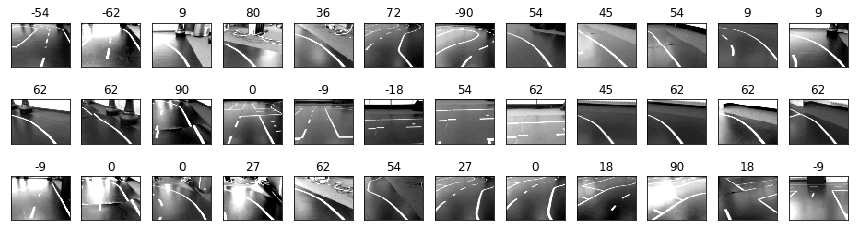

In [26]:
def augment_batch(batch):
    images = [PIL.Image.fromarray(x) for x in batch["image"]]
    images = [augment_img(img) for img in images]
    batch_aug = {'images': np.stack([np.array(img) for img in images])}
    for k, v in batch.items():
        if k != 'images':
            batch_aug[k] = v
    return batch_aug

batch_aug = augment_batch(batch)

fig, axes = plt.subplots(3, 12, figsize=(15, 4))

for ax, img, steering in zip(axes.flat, batch_aug['images'], batch_aug['steering']):
    ax.imshow((img), cmap='gray')
    ax.set_title("{:}".format(int(180*float(steering) / np.pi)))
    ax.set_xticks([])
    ax.set_yticks([])

In [27]:
def batch_to_numpy(batch):
    x = 2.* batch['images'] / 255. - 1 
    y = batch['steering']
    return x[:,:,:,np.newaxis],y

X, y = batch_to_numpy(batch_aug)
print("data: {}, labels: {}".format(X.shape, y.shape))
print("data max: {}, data min: {}".format(X.max(), X.min()))
print("labels max: {}, labels min: {}".format(y.max(), y.min()))

data: (128, 48, 64, 1), labels: (128, 1)
data max: 1.0, data min: -1.0
labels max: 1.5707963705062866, labels min: -1.5707963705062866


In [28]:
gpu_options = tf.GPUOptions(allow_growth=True)
 

sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

x = tf.placeholder(tf.float32, shape=[None, crop_size[1], crop_size[0], 1])
y_true = tf.placeholder(tf.float32, shape=[None, 1])

f = 12
k = 3


# data images are 48x64

l = tf.layers.conv2d(x,f, 5, padding='same')
l = tf.layers.batch_normalization(l)
l = tf.nn.relu(l)
l = tf.layers.max_pooling2d(l, 2, 2)

# 24x32 after pooling
l = tf.layers.conv2d(x,2*f, k, padding='same')
l = tf.layers.batch_normalization(l)
l = tf.nn.relu(l)
l = tf.layers.max_pooling2d(l, 2, 2)

# 12x16
l = tf.layers.conv2d(x,4*f, k, padding='same')
l = tf.layers.batch_normalization(l)
l = tf.nn.relu(l)
l = tf.layers.max_pooling2d(l, (2,2), 2)

# 6x8
l = tf.layers.conv2d(x,8*f, k, padding='same')
l = tf.layers.batch_normalization(l)
l = tf.nn.relu(l)
l = tf.layers.average_pooling2d(l,(6,8),1)
l = tf.contrib.layers.flatten(l)
y_pred = tf.tanh(tf.layers.dense(l,1)) * np.pi

opt = tf.train.AdamOptimizer(learning_rate=0.0003)
loss = tf.reduce_mean((y_pred - y_true)**2)
opt_op = opt.minimize(loss)

init_op = tf.global_variables_initializer()
sess.run(init_op)

history = []

In [15]:
for batch in tqdm(data_generator(n_epoch=7)):
    X,y = batch_to_numpy(augment_batch(batch))
    history.append(sess.run([loss, opt_op], feed_dict={x:X, y_true:y})[0])


13it [00:18,  1.30s/it]

KeyboardInterrupt: 

In [29]:
#saver = tf.train.Saver()
#save_path = saver.save(sess, "../nn_states/model.ckpt")
saver = tf.train.import_meta_graph('../nn_states/model.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('../nn_states/'))

INFO:tensorflow:Restoring parameters from ../nn_states/model.ckpt


In [30]:
result, = sess.run([y_pred], feed_dict={x:X})

In [31]:
#print(result[:])

(array([  3.,   4.,  14.,  16.,  25.,  18.,  15.,  16.,  15.,   2.]),
 array([-0.37524658, -0.28023821, -0.18522984, -0.09022146,  0.00478691,
         0.09979528,  0.19480366,  0.28981203,  0.3848204 ,  0.47982877,
         0.57483715]),
 <a list of 10 Patch objects>)

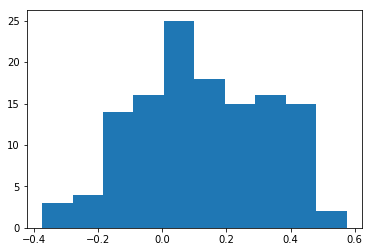

In [32]:
plt.hist(result.flatten())

(0, 1)

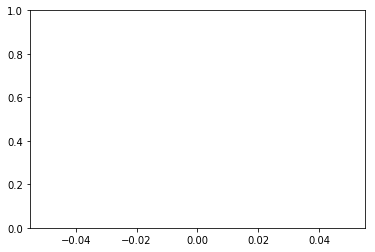

In [33]:
plt.plot(history)
plt.ylim(0,1)

In [34]:
#print(history)

In [36]:
def extract_normalized_images_from(h5_data):
    x = 2.* h5_data['image'][:] / 255. - 1 
    y = h5_data['steering'][:]
    return x[:,6:-6,8:-8,np.newaxis],y

def get_chunks_from(h5_data, chunk_size):
    X,y = extract_normalized_images_from(h5_data)
    for i in range(0, len(X), chunk_size):
        yield X[i: i+chunk_size],y[i: i+chunk_size]
    
tmp = os.path.abspath('../tmp/')
h5_file = h5py.File(os.path.join(data_dir, 'test.hdf5'))
tmp_dir = tempfile.mkdtemp(dir=tmp)
predictions = []
for X,y in get_chunks_from(h5_file, 100):
    prediction = sess.run([y_pred], feed_dict={x:X, y_true:y})
    predictions.append(prediction[0])
predictions = np.concatenate(predictions)    


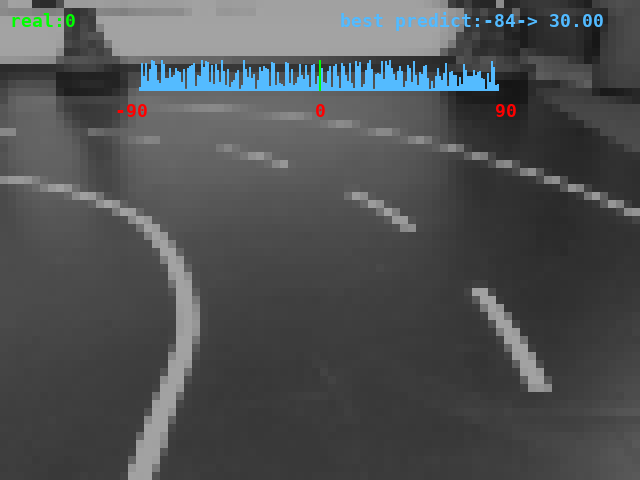

In [71]:
def image_draw_info(img, steering_true, steering_pred, font=None):
    scale = 30
    pred_max = max(steering_pred)
    steering_pred = np.array([xi/pred_max * scale for xi in steering_pred])
    if font is None:
        fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
        mono_fonts = [f for f in fonts if "mono" in f.lower() and 'bold' in f.lower()]
        mono_font = mono_fonts[0]
        font = ImageFont.truetype(mono_font, 18)
    
    
    img = img.resize((640,480))
    img= img.convert("RGBA")
    draw = ImageDraw.Draw(img)

    
    angle = steering_true + np.pi/2
    x = 1/2 * img.size[0]
    y = 90
    x_start = x - 200
    
    legend_color = "#ff0000"
    pred_color = "#0099ffaa"
    draw.text((10,10), "real:{}".format(steering_true), fill="#00ff00ff", font=font)
    draw.text(
        (img.size[0] - 300,10), 
        "best predict:{}-> {:.2f}".format(np.argmax(steering_pred) - 90,max(steering_pred)), 
        fill=pred_color,
        font=font
    )
    
    draw.text((x_start-5, y+10), "-90", fill=legend_color, font=font)
    draw.text((x-5, y+10), "0", fill=legend_color, font=font)
    draw.text((x-5+ 180, y+10), "90", fill=legend_color, font=font)
    for i,prob in enumerate(steering_pred):
        draw.line([x+2*(i-90), y, x+2*(i-90), y-prob], fill=pred_color, width=2)
    
    draw.line([x+steering_true, y, x+steering_true, y - scale], fill="#00ff00ff", width=2)                       
    del draw
    
    return img

def test_image_draw_info():
    img = h5_file['image'][0]
    img = PIL.Image.fromarray(img)
    steering_pred = np.random.random(180) * 40
    img = image_draw_info(img, 0, steering_pred)
    return img
    

test_image_draw_info()



# Evaluate with test set

In [34]:
def save_image(img, i):
    img_fname = os.path.join(tmp_dir, "{:06d}.png".format(i))
    img.save(img_fname)
    
try:
    for i,test_pred,test_real, img in zip(range(len(predictions)), predictions, h5_file['steering'][:], h5_file['image'][:]):
        img = PIL.Image.fromarray(img)
        image_draw_info(img_scale, test_real, test_pred)
        save_image(img_scale,i)
        
    video = ImageSequenceClip(tmp_dir, fps=24, with_mask=False)
    video.write_videofile("test_set_evaluation.webm", ffmpeg_params=['-b:v', '0', '-crf', '20'])
finally:        
    shutil.rmtree(tmp_dir)


[MoviePy] >>>> Building video test_set_evaluation.webm
[MoviePy] Writing video test_set_evaluation.webm


100%|██████████| 3591/3591 [00:38<00:00, 94.02it/s] 

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_set_evaluation.webm 



In [ ]:
predictions[0].shape